In [ ]:
print("The start of Optimisation HW1!")
print("These are not the droids you're looking for")

The start of Optimisation HW1!
These are not the droids you're looking for


In [24]:
#Import relevant libraries
import sklearn
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import scipy.linalg
import time

In [41]:
def createDataset():
    #Let's start to generate the points using two functions: sine and cosine
    range = (-5*np.pi, 5*np.pi)
    n = 5000 #number of points
    x_0 = np.random.uniform(*range, n//2)
    f_sin = np.sin(0.6*x_0) #function for class -1
    f_cos = np.cos(0.6*x_0+np.pi/2) #fuction for class 1

    #Visualize the graphs without noise
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos without noise")
    plt.scatter(x_0, f_sin, alpha=0.6, s=30)
    plt.scatter(x_0, f_cos, alpha=0.6, s=30)
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    #Let's add some noise 
    noise = np.random.normal(0, 0.1, len(x_0))
    new_fsin = f_sin + noise
    new_fcos = f_cos + noise 

    #Graphs visualization with noise 
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos with noise")
    plt.scatter(x_0, new_fsin, alpha=0.6, s=30)
    plt.scatter(x_0, new_fcos, alpha=0.6, s=30)
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    class_0 = np.array(list(zip(x_0, new_fsin)))
    class_1 = np.array(list(zip(x_0, new_fcos)))

    return class_0, class_1

def split_data(class0, class1, labeled_pct, initialize_random=True):
    scaler = StandardScaler().fit(np.concatenate((class0, class1)))
    split_0 = int(len(class0) * labeled_pct) #number of data with labels according to percentage provided for class 0
    split_1 = int(len(class1) * labeled_pct) #same for class 1

    x_bar_0 = scaler.transform(class0[:split_0]) #transforms on the range of the labeled data 
    x_bar_1 = scaler.transform(class1[:split_1])
    x_0 = scaler.transform(class0[split_0:]) #transforms on the range of the unlabeled data 
    x_1 = scaler.transform(class1[split_1:])

    #Creating the labels and variables for label and unlabel data 
    y_bar_0 = np.full(len(x_bar_0), -1) #assigns -1 to a vector of size x_bar_0, creating labeled data for class -1
    y_bar_1 = np.full(len(x_bar_1), 1)  #assigns 1 to a vector of size x_bar_1, creating labeled data for class 1 
    y_0 = np.full(len(x_0), -1) #creating the target vector for class -1
    y_1 = np.full(len(x_1), 1) #creating the target vector for class 1 

    #Concatenates variables of both classes to create label and unlabel variables 
    x_labeled = np.concatenate((x_bar_0, x_bar_1)) #list of coordinates (x, y) of labeled data 
    y_labeled = np.concatenate((y_bar_0, y_bar_1)) #list of classes 
    x_unlabeled = np.concatenate((x_0, x_1)) #list of coordiantes (x, y) of unlabeled data
    y_unlabeled_target = np.concatenate((y_0, y_1)) #list of target classes

    #2 ways to initialize the labels to predict 
    if initialize_random:
        y_unlabeled_initial = np.random.choice([-1, 1], len(x_unlabeled))
    else:
        y_unlabeled_initial = np.zeros(len(x_unlabeled))

    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

def plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Unlabeled points true value")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]], alpha=0.6, s=30)
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]], alpha=0.6, s=30)
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled points true value")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30)
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled and unlabeled points")
    plt.scatter([p[0] for p in x_unlabeled], [p[1] for p in x_unlabeled], c="grey")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30)
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30)
    plt.legend(["Unlabeled", "Labeled 1", "Labeled -1"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    return 

def prepareArtifitialData():
    class0, class1 = createDataset()
    x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = split_data(class0, class1, 0.1)
    plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target)
    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

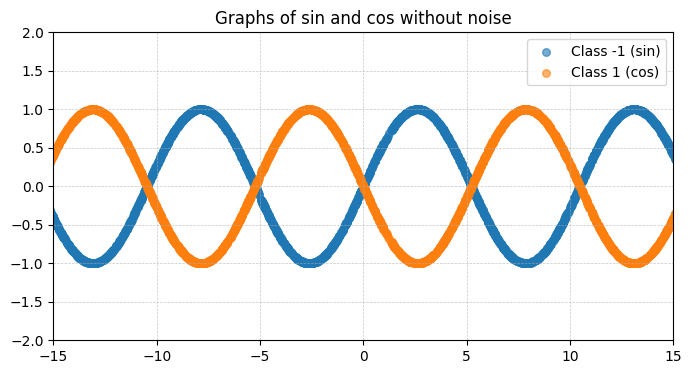

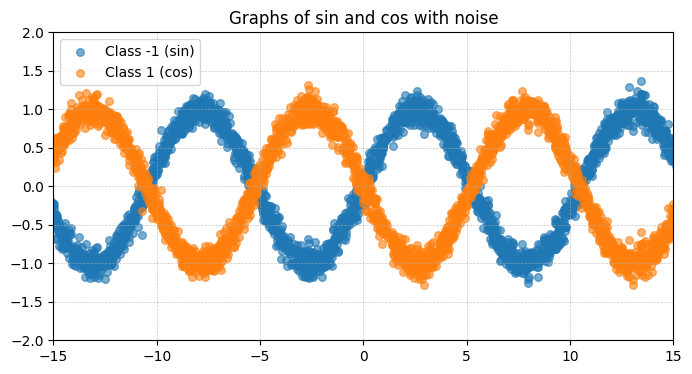

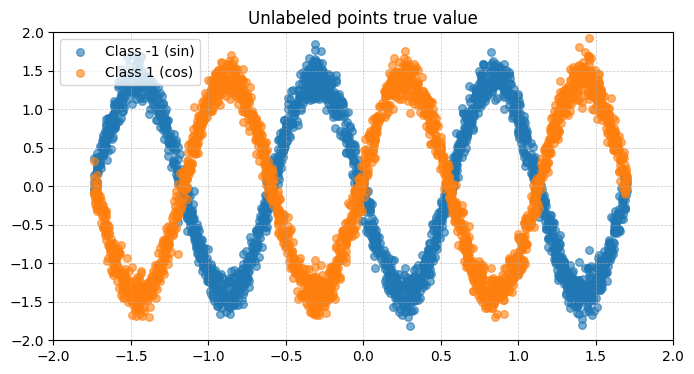

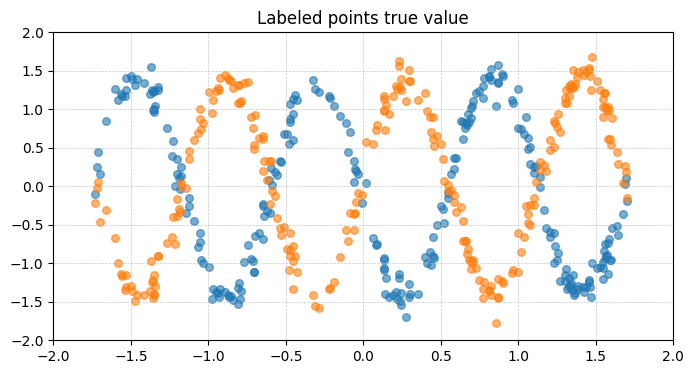

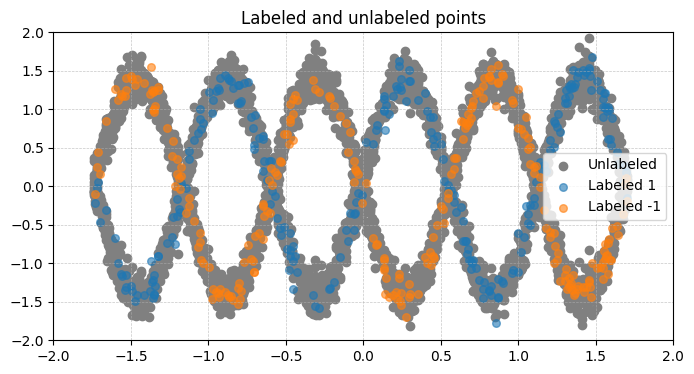

In [42]:
x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = prepareArtifitialData()

In [43]:
# Define weight arrays using Gaussian (RBF) Kernel as similarity measure 

#Array w_ij is the weights array between labeled examples and unlabeled examples
w_rows = []

for i in x_labeled:
    row = []
    for j in x_unlabeled:
        d = np.exp(-0.5*(math.dist(i, j))**2) #computes the RBF similarity between labeled and unlabeled data
        row.append(d)
    w_rows.append(row)

w_ij= np.array(w_rows)

#Array w_ij_bar is the weights array between unlabeled examples and unlabeled examples
w_rows_bar = []

for i in x_unlabeled:
    row=[]
    for j in x_unlabeled:
        d = np.exp(-0.5*(math.dist(i, j))**2) #computes the RBF similarity between unlabeled data
        row.append(d)
    w_rows_bar.append(row)

w_ij_bar = np.array(w_rows_bar)

print(w_ij.shape, w_ij_bar.shape)

(500, 4500) (4500, 4500)


In [44]:
w_ij_bar[0:5]

array([[1.        , 0.04514957, 0.38099617, ..., 0.11569558, 0.54942738,
        0.316858  ],
       [0.04514957, 1.        , 0.01404198, ..., 0.03618827, 0.36218325,
        0.04915583],
       [0.38099617, 0.01404198, 1.        , ..., 0.5978901 , 0.25085525,
        0.01589678],
       [0.2203951 , 0.29994004, 0.01694876, ..., 0.00934997, 0.42938916,
        0.64074147],
       [0.91433011, 0.08206032, 0.53148321, ..., 0.2432115 , 0.71967957,
        0.2097858 ]])

In [45]:
#Implement BCGD

#First, define the loss function

def loss(given_labels, predicted_labels):
    
   #Representing points as vectors for ease of calculations
    y = np.copy(predicted_labels).astype("float64").reshape((-1,1))
    y_bar = np.copy(given_labels).astype("float64").reshape((-1,1))

    diff_t1 = y-y_bar.T
    diff_t1_sq = np.power(diff_t1,2)
    loss_matrix_t1 = diff_t1_sq*w_ij.T
    total_loss_t1 = np.sum(loss_matrix_t1)

    diff_t2 = y-y.T
    diff_t2_sq = np.power(diff_t2,2)
    loss_matrix_t2 = diff_t2_sq*w_ij_bar.T
    total_loss_t2 = np.sum(loss_matrix_t2)

    return total_loss_t1 + total_loss_t2


In [46]:
#Define accuracy measures
# accuracy score, rounding current to {-1,1} and comparing with target
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)

# accuracy from a loss point of view, however it has the problem that
# the minimum of the loss might be greater than 0
max_loss = np.sum(w_ij) * 4 + np.sum(w_ij_bar) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

# accuracy from a target point of view, aka distance from current to target
initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=1)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=1)
    return 1 - current_distance / initial_distance

# the accuracy used as proxy to switch from one to another
def accuracy(current):
    return accuracy_norm(current)

In [47]:
#Define Hessian Matrix to estimate Lipschitz constant

USE_LIPSCHITZ_CONSTANT = True
OUTPUT_STEP = 0.1
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
STEP_SIZE = 1e-2

def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat * 2

def estimate_lipschitz_constant(hessian):
    # max eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

def estimate_degree_strongly_convex(hessian):
    # min eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(w_ij_bar, w_ij)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 304.9791535141568,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 4297.393351339991
Estimating Lipschitz constant for each single variable
Done


In [48]:
#Calculating constants that will be used in the Gradient Descent Method

print("Calculating coefficients of the gradient")
row_sum_w = np.sum(w_ij, axis=0).reshape((-1,1))
row_sum_w_ = np.sum(w_ij_bar, axis=0).reshape((-1,1))
Cij = (row_sum_w + row_sum_w_)
b = np.multiply(
    y_labeled.reshape((-1,1)),
    w_ij
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


In [49]:
#Defining the gradient function

def gradient(y):
    unlabeled = y.reshape((-1,1))
    third_coeff = np.dot(w_ij_bar.T, y)
    return 2 * (Cij * unlabeled - b - third_coeff).reshape((-1,))

In [50]:
#Defining functions for the gradient calculation for block selection

def derivative(y, j):
    return 2 * (Cij[j] * y[j] -
           b[j] -
           np.matmul(w_ij_bar[:,j], y.T))

def update_gradient(previous_grad, Li, index):
    global w_ij_bar, Cij
    step = 1/Li * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += 2* w_ij_bar[index] * step
    new_grad[index] -= 2 * Cij[index] * step
    return step, new_grad

In [51]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [56]:
gradient(y_unlabeled_bcgd_gs).shape

(20250000,)

In [52]:
#Implement the BCGD with GS

NUM_ITERS = 50
CREATE_GIF = False

ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    if CREATE_GIF and (not FROM_DATASET or x_labeled.shape[1] == 2) and i % len(y_unlabeled_target) == 0:
        create_frame_points_scale(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs, "./gif/bcgd_gs/", "BCGD Gauss-Southwell")
        create_frame_points_binary(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs, "./gif/bcgd_gs_binary/", "BCGD Gauss-Southwell")
        create_frame_loss(i // len(y_unlabeled_target), losses_bcgm_gs, "./gif/loss_bcgd_gs/", "BCGM Gauss-Southwell")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li[index], index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 225000

IndexError: index 6021424 is out of bounds for axis 0 with size 4500

In [ ]:
y=np.copy([1,2,3,4,5,6,7,8,9,10]).astype("float64").reshape((-1,1))
y_bar = np.copy([1,2]).astype("float64").reshape((-1,1))

np.power(y - y_bar.T,2)

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 4.,  1.],
       [ 9.,  4.],
       [16.,  9.],
       [25., 16.],
       [36., 25.],
       [49., 36.],
       [64., 49.],
       [81., 64.]])